In [1]:
import os
import time
import re

import h5py
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from utils_plot import *

In [2]:
model_name = 'nf'
dataset = 'test' # train/val/test
epoch = 499 # replace with epoch used for generation

## Load generated

In [3]:
nphotons = 2
outdir = os.path.join('./trained_results', model_name)
h5_dir = os.path.join(outdir, 'h5')
img_dir = os.path.join(outdir, 'imgs')
os.makedirs(img_dir, exist_ok=True)

sample = '{}{:04d}'.format(dataset, epoch)
file = os.path.join(h5_dir, sample+'.hdf5')

In [4]:
f = h5py.File(file, 'r')
truth_in_scale = f['scale'][()]
input_data_scale = f['condition_scale'][()]
cond_keep = f['condition_keep'][()]
f.close()

In [5]:
test_in = pd.read_hdf(file, 'condition')
predictions = pd.read_hdf(file, 'generated')
test_truth = pd.read_hdf(file, 'simulated')
pred_feat = pd.read_hdf(file, 'generated_reco')
truth_feat = pd.read_hdf(file, 'simulated_reco')

In [6]:
labels_in = list(test_in.columns)
labels = list(test_truth.columns)
labels_feat = list(pred_feat.columns)

In [7]:
test_pred = predictions.to_numpy()
test_truth = test_truth.to_numpy()

In [8]:
test_in_scaled = test_in.to_numpy() * input_data_scale

In [9]:
distances = [stats.wasserstein_distance(test_pred[:, idx], test_truth[:, idx]) for idx in range(test_pred.shape[1])]
np.average(distances)

0.0009339342266026029

## Plots

### Generated vs simulated distribution

In [10]:
test_pred_all = np.concatenate([test_pred[:,:3], test_pred[:,3:]])
test_truth_all = np.concatenate([test_truth[:,:3], test_truth[:,3:]])

In [11]:
test_pred_all_reorder = test_pred_all[:, [0, 2, 1]]
test_truth_all_reorder = test_truth_all[:, [0, 2, 1]]

In [12]:
labels = ['${E_T}^{reco} - {E_T}^{truth}$', '$\eta^{reco} - \eta^{truth}$', '$\phi^{reco} - \phi^{truth}$']
titles = None

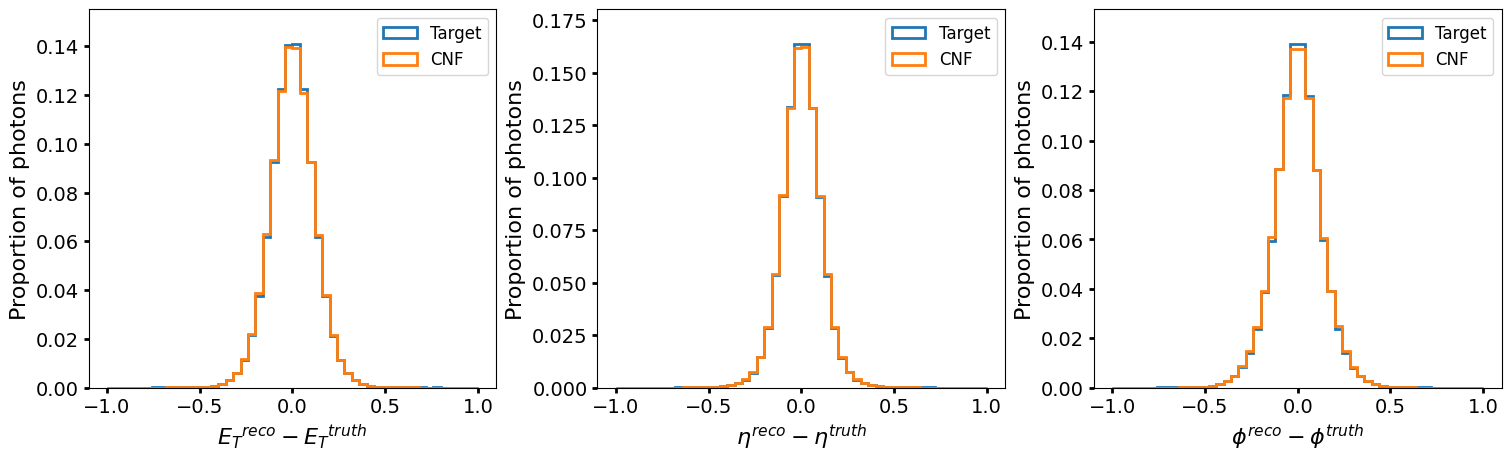

In [13]:
# normalized
save_path = os.path.join(img_dir, '{}_pred_all.pdf'.format(sample))
compare(test_pred_all_reorder, test_truth_all_reorder, img_dir, epoch, [-1, 1], labels, 1, 
        titles, save_path=save_path, show=True)

In [14]:
truth_in_scale_all_reorder = truth_in_scale[[0, 2, 1]]

In [15]:
labels = ['${E_T}^{reco} - {E_T}^{truth}$ [GeV]', '$\eta^{reco} - \eta^{truth}$', '$\phi^{reco} - \phi^{truth}$']
titles = None

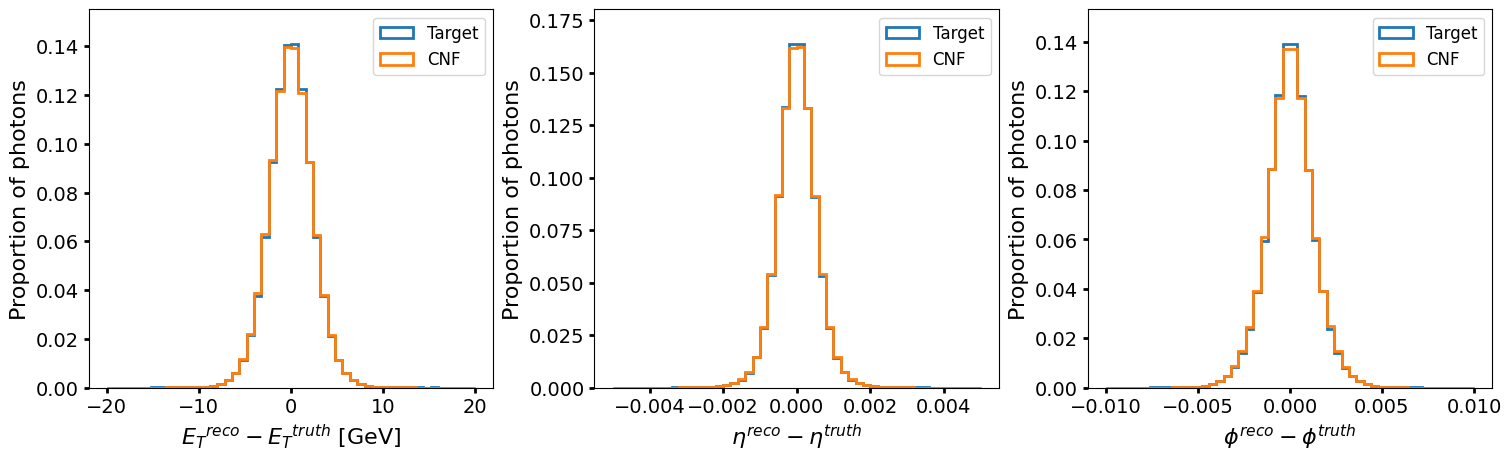

In [16]:
# physical scale
save_path = os.path.join(img_dir, '{}_pred_all_scale.pdf'.format(sample))
compare(test_pred_all_reorder * truth_in_scale_all_reorder, test_truth_all_reorder * truth_in_scale_all_reorder, 
        img_dir, epoch, [-1, 1], labels, 1, titles, scale=truth_in_scale_all_reorder, save_path=save_path, show=True)

In [17]:
test_pred_reorder = test_pred[:, [0, 2, 1, 3, 5, 4]]
test_truth_reorder = test_truth[:, [0, 2, 1, 3, 5, 4]]

In [18]:
labels = ['${E_T}^{reco} - {E_T}^{truth}$', '$\eta^{reco} - \eta^{truth}$', '$\phi^{reco} - \phi^{truth}$'] * 2
titles = ['Leading photon'] * 3 + ['Sub-leading photon'] * 3

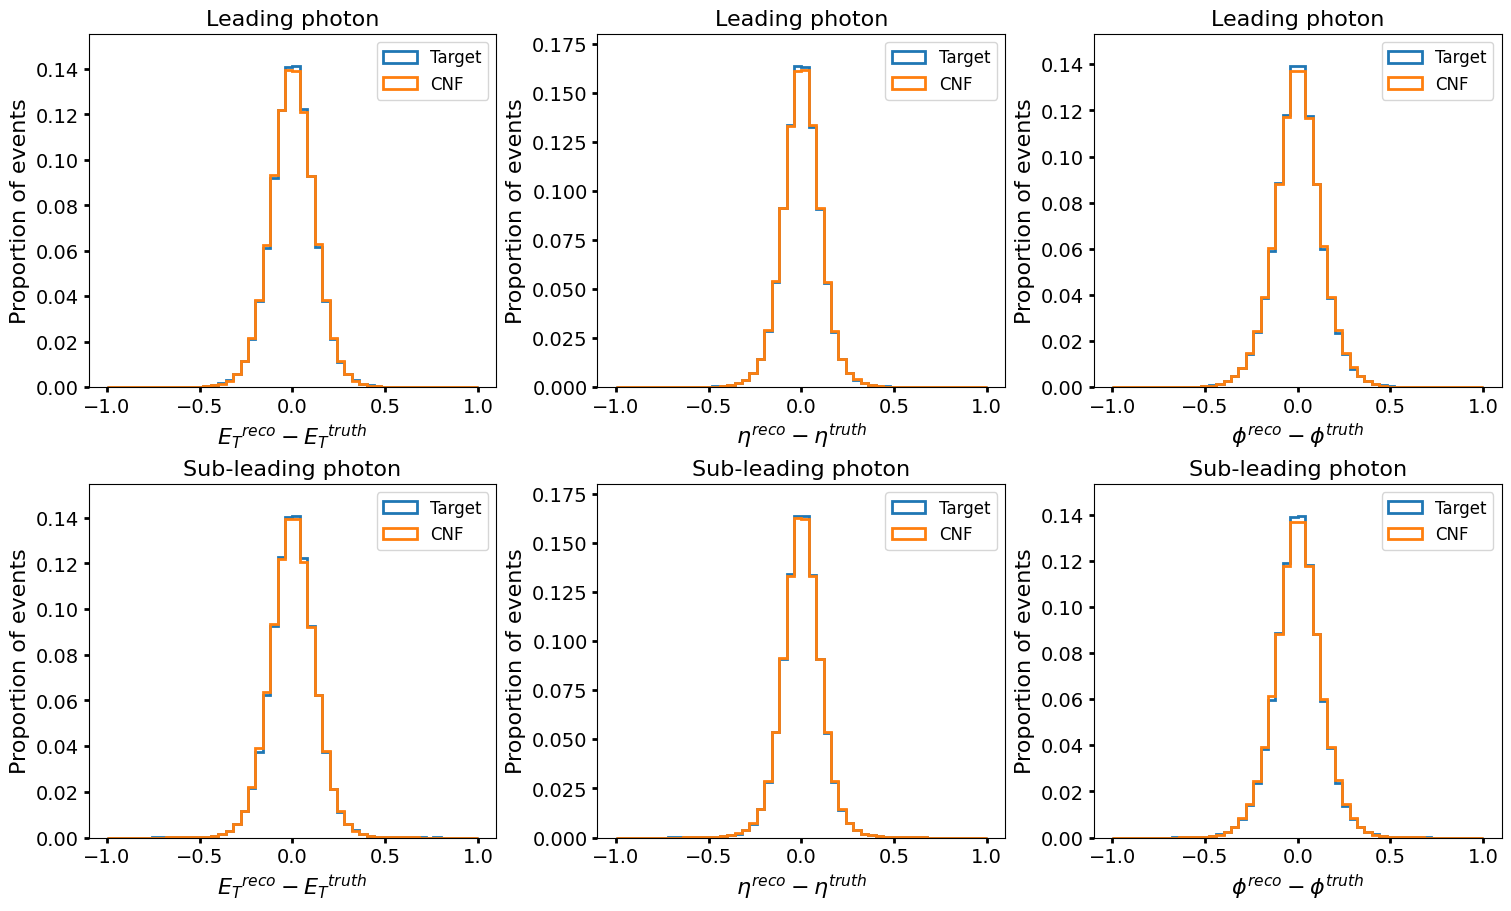

In [19]:
save_path = os.path.join(img_dir, '{}_pred.pdf'.format(sample))
compare(test_pred_reorder, test_truth_reorder, img_dir, epoch, [-1, 1], labels, nphotons, 
        titles, save_path=save_path, show=True)

In [20]:
pred_feat_all = np.concatenate([pred_feat.iloc[:,:3].to_numpy(), pred_feat.iloc[:,3:].to_numpy()])
truth_feat_all = np.concatenate([truth_feat.iloc[:,:3].to_numpy(), truth_feat.iloc[:,3:].to_numpy()])

In [21]:
pred_feat_all_reorder = pred_feat_all[:, [0, 2, 1]]
truth_feat_all_reorder = truth_feat_all[:, [0, 2, 1]]

In [22]:
labels = ['${E_T}^{reco}$ [GeV]', '$\eta^{reco}$', '$\phi^{reco}$']
titles = None

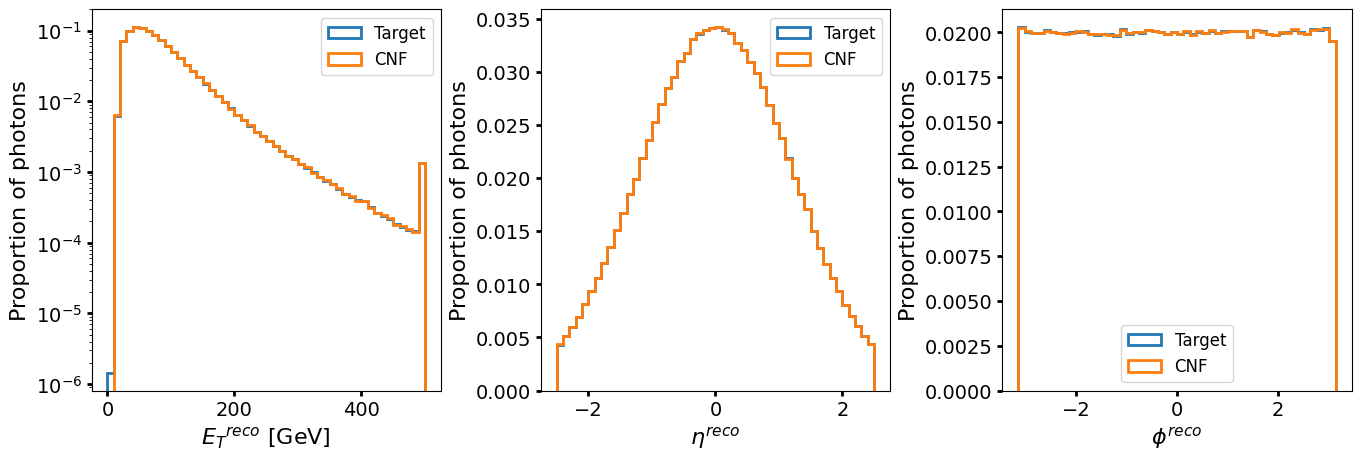

In [24]:
save_path = os.path.join(img_dir, '{}_pred_reco_all_logET.pdf'.format(sample))
compare_feat(pred_feat_all_reorder, truth_feat_all_reorder, img_dir, epoch, labels, 1, 
             logET=True, x_ranges = [[0, 500], [-2.5, 2.5], [-np.pi, np.pi]],
             titles=titles, save_path=save_path, show=True)

In [25]:
pred_feat_reorder = pred_feat.to_numpy()[:, [0, 2, 1, 3, 5, 4]]
truth_feat_reorder = truth_feat.to_numpy()[:, [0, 2, 1, 3, 5, 4]]

In [26]:
labels = ['${E_T}^{reco}$', '$\eta^{reco}$', '$\phi^{reco}$'] * 2
titles = ['Leading photon'] * 3 + ['Sub-leading photon'] * 3

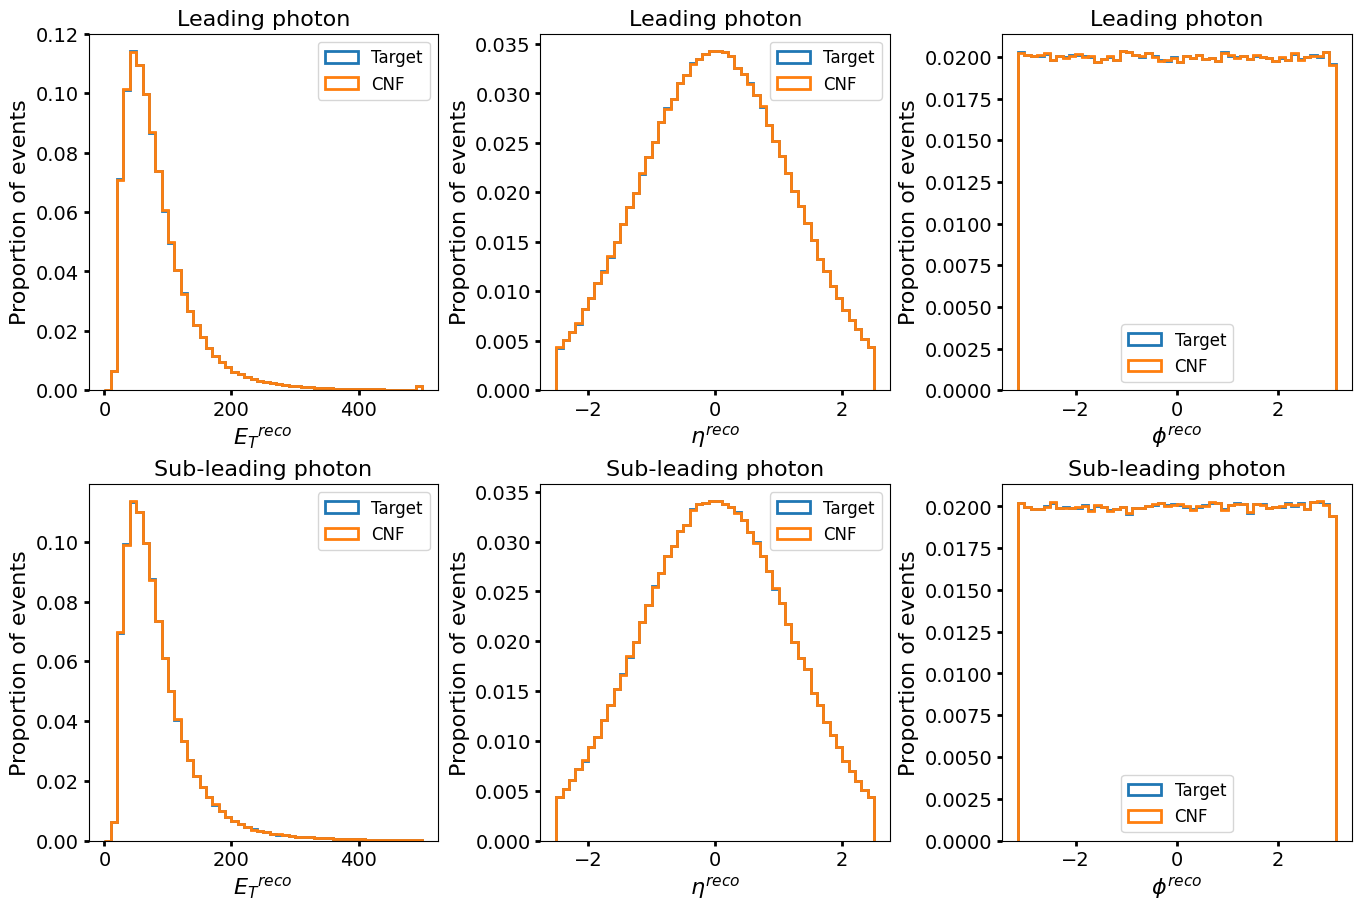

In [27]:
save_path = os.path.join(img_dir, '{}_pred_reco.pdf'.format(sample))
compare_feat(pred_feat_reorder, truth_feat_reorder, img_dir, epoch, labels, nphotons, 
             x_ranges = [[0, 500], [-2.5, 2.5], [-np.pi, np.pi]],
             titles=titles, save_path=save_path, show=True)

### Correlation

In [28]:
labels = ['${E_T}^{reco} - {E_T}^{truth}$ \n leading', 
          '$\eta^{reco} - \eta^{truth}$ \n leading',
          '$\phi^{reco} - \phi^{truth}$ \n leading', 
          '${E_T}^{reco} - {E_T}^{truth}$ \n sub-leading', 
          '$\eta^{reco} - \eta^{truth}$ \n sub-leading',
          '$\phi^{reco} - \phi^{truth}$ \n sub-leading']

In [29]:
test_pred_reorder = test_pred[:, [0, 2, 1, 3, 5, 4]]
test_truth_reorder = test_truth[:, [0, 2, 1, 3, 5, 4]]

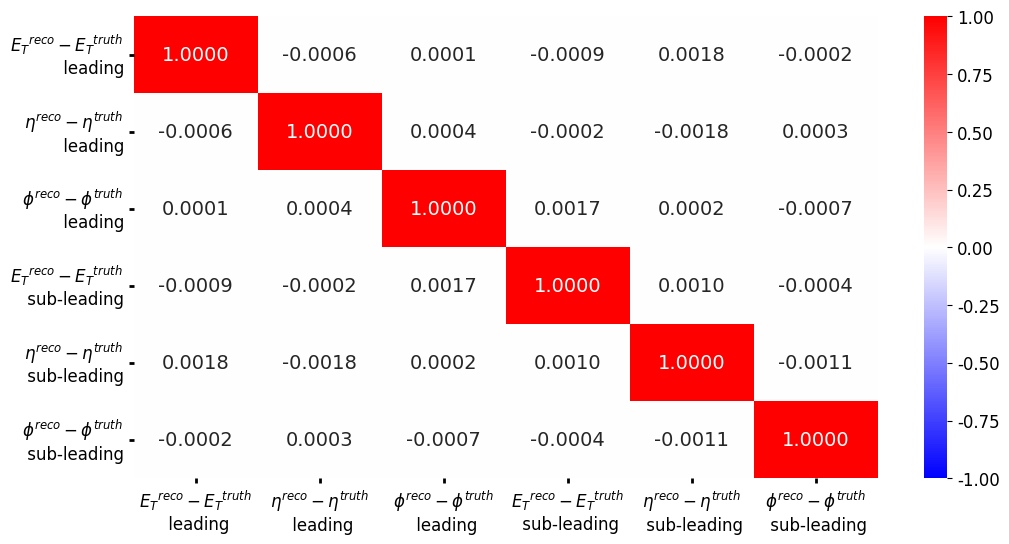

In [30]:
save_path = os.path.join(img_dir, '{}_pred_corr.pdf'.format(sample))
plot_corr(test_pred_reorder, img_dir, epoch, labels, save_path=save_path, show=True)

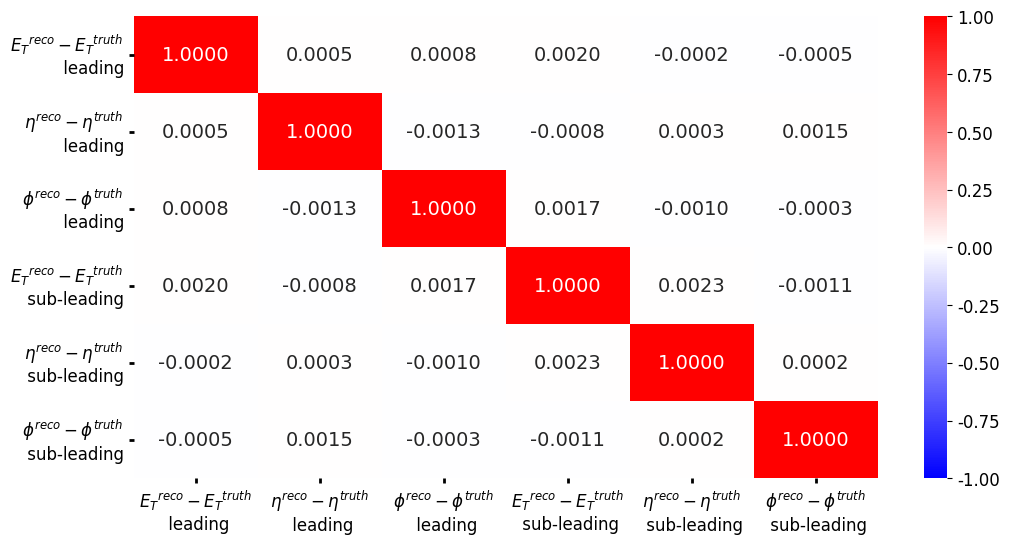

In [31]:
save_path = os.path.join(img_dir, '{}_truth_corr.pdf'.format(sample))
plot_corr(test_truth_reorder, img_dir, epoch, labels, save_path=save_path, show=True)

In [32]:
labels_feat = ['${E_T}^{reco}$ \n leading', 
               '$\phi^{reco}$ \n leading', 
               '$\eta^{reco}$ \n leading',
               '${E_T}^{reco}$ \n sub-leading', 
               '$\phi^{reco}$ \n sub-leading', 
               '$\eta^{reco}$ \n sub-leading']

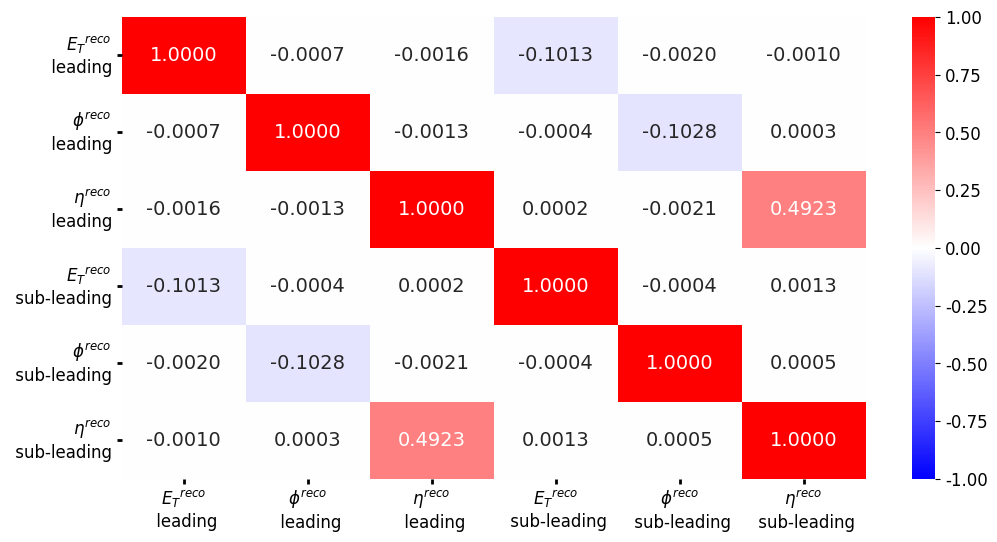

In [33]:
save_path = os.path.join(img_dir, '{}_pred_reco_corr.pdf'.format(sample))
plot_corr(pred_feat, img_dir, epoch, labels_feat, save_path=save_path, show=True)

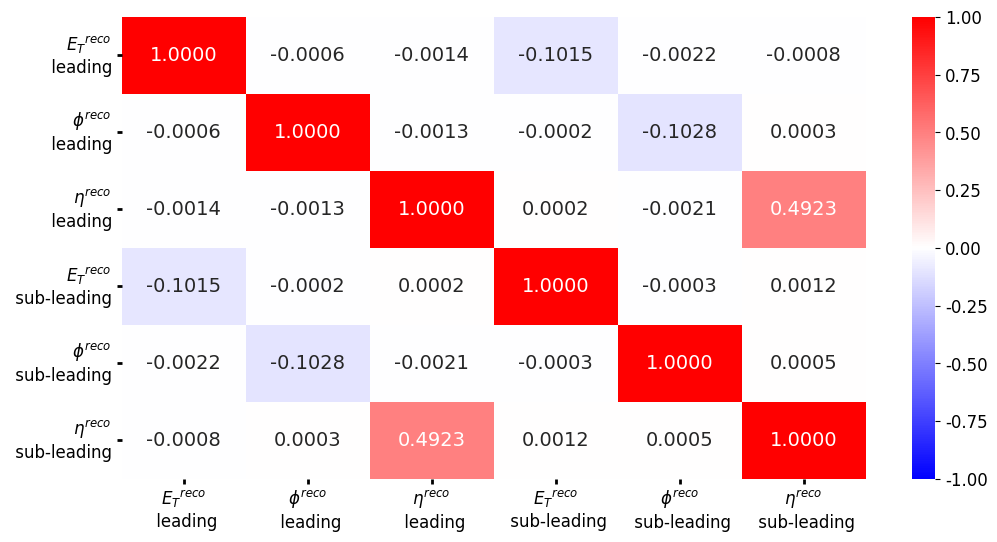

In [34]:
save_path = os.path.join(img_dir, '{}_truth_reco_corr.pdf'.format(sample))
plot_corr(truth_feat, img_dir, epoch, labels_feat, save_path=save_path, show=True)

### Diphoton system

499 myy
Range (120, 130), # events in range, total # events, proportion of events in range
Target: 582388 700980 0.8308197095494878
CNF: 581960 700980 0.8302091357813347
Mean, sd for range (120, 130)
Target: 124.9901693016422 2.335549800176056
CNF: 124.98315660174309 2.33848535937721


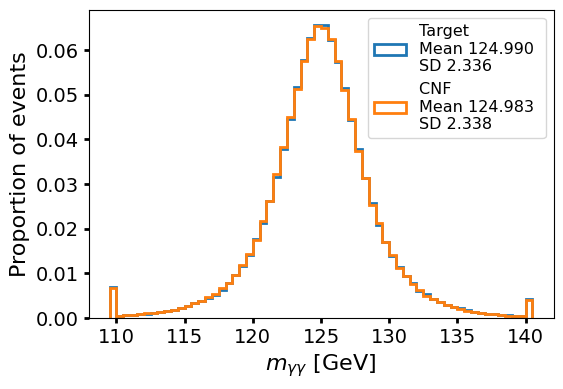

In [35]:
save_path = os.path.join(img_dir, '{}_myy.pdf'.format(sample))
plot_myy(pred_feat, truth_feat, img_dir, epoch, save_path=save_path, show=True)

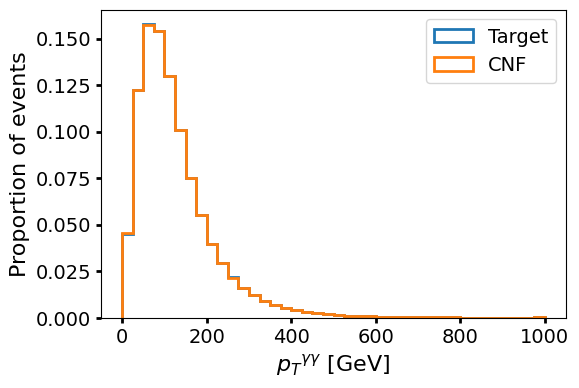

499 yy_pt
Range [0, 400), # events in range, total # events, proportion of events in range
Target: 687547 700980 0.9808368284401837
CNF: 687493 700980 0.9807597934320522
Mean, sd for range [0, 400)
Target: 118.98286011179961 76.38533400079031
CNF: 118.94853137275304 76.3466314271145


In [36]:
save_path = os.path.join(img_dir, '{}_yy_pt.pdf'.format(sample))
plot_yy_pt(pred_feat, truth_feat, img_dir, epoch, save_path=save_path, show=True)

### Resolution

In [37]:
test_truth = test_truth_all
test_pred = test_pred_all

In [38]:
test_truth_keep = test_truth
num_events = test_truth_keep.shape[0]
num_events_new = -1
while num_events != num_events_new:
    num_events = num_events_new
    truth_mean = test_truth_keep.mean(axis=0)
    truth_std = test_truth_keep.std(axis=0)
    
    is_test_truth_keep = (test_truth >= (truth_mean - 3*truth_std)) & (test_truth <= (truth_mean + 3*truth_std))
    test_truth_keep = test_truth[is_test_truth_keep.all(axis=1)]
    num_events_new = test_truth_keep.shape
    
predictions_keep = test_pred
num_events = predictions_keep.shape[0]
num_events_new = -1
while num_events != num_events_new:
    num_events = num_events_new
    pred_mean = predictions_keep.mean(axis=0)
    pred_std = predictions_keep.std(axis=0)
    
    is_predictions_keep = (test_pred >= (pred_mean - 3*pred_std)) & (test_pred <= (pred_mean + 3*pred_std))
    predictions_keep = test_pred[is_predictions_keep.all(axis=1)]
    num_events_new = predictions_keep.shape
    
is_keep = is_predictions_keep.all(axis=1) & is_test_truth_keep.all(axis=1)

In [39]:
print('Number of events kept:', sum(is_keep), len(is_keep))
print(np.mean(is_keep))

Number of events kept: 1314733 1401960
0.9377821050529259


In [40]:
def calculate_sd(truth, pred, k):
    # keep = (truth >= -0.5) & (truth <= 0.5) & (pred >= -0.5) & (pred <= 0.5)
    # truth = truth[keep] * truth_in_scale[k]
    # pred = pred[keep] * truth_in_scale[k]
    
    truth = truth * truth_in_scale[k]
    pred = pred * truth_in_scale[k]

    if len(pred) == 0:
        pred_m, pred_s = 0, 0
    else:
        pred_m, pred_s = pred.mean(), pred.std()
    if len(truth) == 0:
        truth_m, truth_s = 0, 0
    else:
        truth_m, truth_s = truth.mean(), truth.std()
    return pred_m, pred_s, len(pred), truth_m, truth_s, len(truth)

In [41]:
pt_range = np.arange(0, 201, 20)[2:]
phi_range = np.arange(-3, 3.01, 0.5)
eta_range = np.arange(-2, 2.01, 0.5)
pileup_range = np.arange(0, 46, 5)[1:-2]

In [42]:
feat_map = {'pt': [pt_range, 0], 'phi': [phi_range, 1], 'eta': [eta_range, 2], 'pileup': [pileup_range, -1]}

In [43]:
def compute_resolution(feat, nphotons):
    feat_range, offset = feat_map[feat]
    n = len(feat_range)+1

    num_bins = 3 * nphotons
    pred_means = np.zeros((n, num_bins))
    pred_sds = np.zeros((n, num_bins))
    truth_means = np.zeros((n, num_bins))
    truth_sds = np.zeros((n, num_bins))

    pred_count = np.zeros((n, num_bins))
    truth_count = np.zeros((n, num_bins))
    count = np.zeros((n, num_bins))

    for i in range(n):
        for k in range(num_bins):
            idx = (k//3)*3 + offset
            if feat == 'pileup':
                idx = -1

            # binning
            title = ''
            if i == 0:
                x = (test_in_scaled[:,idx] < feat_range[i])
                title += feat+' < '+str(feat_range[i])
            elif i == n-1:
                x = (test_in_scaled[:,idx] >= feat_range[i-1])
                title += str(feat_range[i-1])+' <= '+feat
            else:
                x = (test_in_scaled[:,idx] >= feat_range[i-1]) & (test_in_scaled[:,idx] < feat_range[i])
                title += str(feat_range[i-1])+' <= '+feat+' < '+str(feat_range[i])

            x = x & is_keep
            pred_m, pred_s, pred_c, truth_m, truth_s, truth_c = calculate_sd(test_truth[x,k], test_pred[x,k], k)
            pred_means[i,k] = pred_m
            pred_sds[i,k] = pred_s
            pred_count[i,k] = pred_c

            truth_means[i,k] = truth_m
            truth_sds[i,k] = truth_s
            truth_count[i,k] = truth_c

            count[i,k] = sum(x)

    truth_count = truth_count.astype(int)
    pred_count = pred_count.astype(int)
    count = count.astype(int)
    return truth_sds, pred_sds, feat_range, offset

In [44]:
test_in_scaled = np.concatenate([test_in_scaled[:,[0,1,2,6]], test_in_scaled[:,[3,4,5,6]]])

In [45]:
labels = ['$\sigma_{{E_T}^{reco} - {E_T}^{truth}}$',
          '$\sigma_{\eta^{reco} - \eta^{truth}}$',
          '$\sigma_{\phi^{reco} - \phi^{truth}}$']
labels_in = ['${E_T}^{truth}$ [GeV]', '$\phi^{truth}$', '$\eta^{truth}$', '$\mu$']
labels_hist = ['${E_T}^{reco}$', '$\phi^{reco}$', '$\eta^{reco}$']

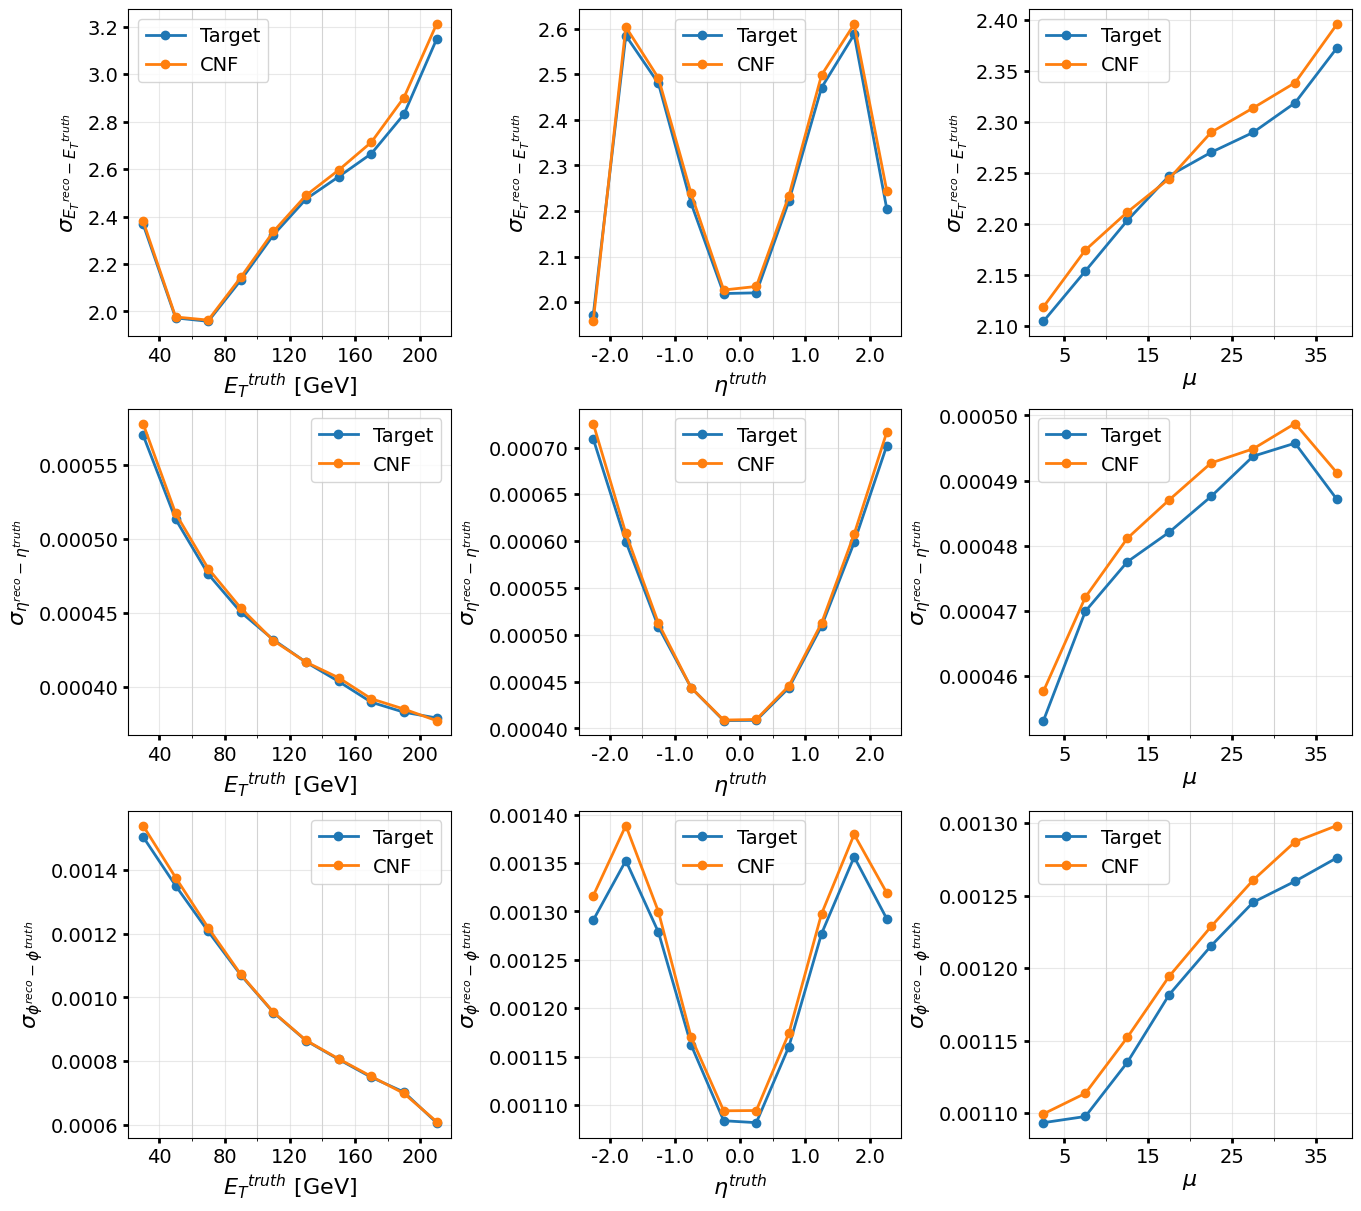

In [46]:
nphotons = 1
ncol = 3
nrow = 3
num_bins = 3 * nphotons

fig, axs = plt.subplots(nrow, ncol, figsize=(4.5*ncol, 4*nrow), constrained_layout=True)
axs = axs.flatten()
config = dict(lw=2, marker='o')

feats = ['pt', 'eta', 'pileup']

for col in range(3):
    feat = feats[col]
    res = compute_resolution(feat, nphotons)
    truth_sds, pred_sds, feat_range, offset = res
    n = len(feat_range)+1

    for idx, idx_feat in enumerate([0, 2, 1]):
        ax = axs[idx%3*ncol + col]
        ax.plot(truth_sds[:, idx_feat], label='Target', **config)
        ax.plot(pred_sds[:, idx_feat], label='CNF', **config)

        if feat == 'pileup':
            ax.set_xlabel('$\mu$', fontsize=fontsize)
        else:
            ax.set_xlabel(labels_in[idx_feat//3*ncol+offset], fontsize=fontsize)
        ax.set_ylabel(labels[idx], fontsize=fontsize)
        
        ax.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
        ax.set_xticks(ticks=np.arange(0.5, n-0.5, 2), labels=feat_range[::2])
        ax.set_xticks(ticks=np.arange(1.5, n-0.5, 2), minor=True)

        ax.xaxis.grid(True, which='major', c='lightgray')
        ax.xaxis.grid(True, which='minor', c='lightgray')
        ax.yaxis.grid(True, c='lightgray')
        ax.legend(fontsize=minor_size)
    
save_path = os.path.join(img_dir, '{}_resolution.pdf'.format(sample))
plt.savefig(save_path, bbox_inches='tight');